# Twitter US Airline Sentiment - AI Fellowship Challenge

In this challenge we will use the tranfer learning methodology [ULMFiT](http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html) in NLP and build a classifer to predict the correct sentiment for [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv) dataset.

**Main Steps**
* Utilize pretrained general Language Model(based on WiKi103 data set) from fastai library to build a Airline tweets specific Language Model.
* Using the trained Airline Tweets Specific Language model, we will build a classifier model to predict the sentiment of Airline twitter feed.

**Final Results**
* Accuracy of our classier is over 95%. This high accuracy level is due to including 'negativereason' column data along with 'text' column data for fine tuning the models

## Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from fastai.imports import core
from fastai.text import data, learner, models
import warnings
warnings.filterwarnings("ignore")

## Data

In [5]:
path = core.Path('../../data/twitter_airline_sentiment/')

In [6]:
path.ls()

[PosixPath('../../data/twitter_airline_sentiment/Tweets_cleaned.csv'),
 PosixPath('../../data/twitter_airline_sentiment/data_save.pkl'),
 PosixPath('../../data/twitter_airline_sentiment/Tweets.csv.zip'),
 PosixPath('../../data/twitter_airline_sentiment/models'),
 PosixPath('../../data/twitter_airline_sentiment/Tweets.csv')]

In [8]:
df = core.pd.read_csv(path/'Tweets.csv')

In [9]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
print("The number of nulls in each column are \n", df.isna().sum())

The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


We see that there are two columns "text" and "negativereason" that has text which could be useful for model training. The column "negativereason" has NaN values that we need to replace with single space to be able to use in the model.

In [11]:
df['negativereason'].fillna(" ", inplace=True)

In [12]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [13]:
df.to_csv(path/'Tweets_cleaned.csv', index=False)

## Language Model

In this section we will build a language model (more specifically tune a pre-trained model) specific to US Airline Tweets. We will use fastai pretrained "AWD_LSTM" wiki103 language model as starting point and tune that to the best accuracy we can get using the US Airline Tweets data. This should help our model in understanding the Airline specific language.

In [14]:
bs = 32

In [16]:
#Build the data bunch for Language model training
data_lm = data.TextLMDataBunch.from_csv(path, 'Tweets_cleaned.csv', text_cols=['text', 'negativereason'], label_cols=1)

In [17]:
data_lm.show_batch()

idx,text
0,yourselves to blame for giving me the time to get drunk and tell you how i feel about your overpriced sub par airline xxmaj ca n't xxmaj tell xxbos @united well the xxunk flight to dca to take us to ewr was delayed and it made us miss our connection to xxup fll so yes hotels were necessary xxmaj late xxmaj flight xxbos @united will do . xxmaj thx .
1,"weeks is xxunk , am i really supposed to go that long with out a car seat for my child . xxmaj ridiculous ! xxmaj customer xxmaj service xxmaj issue xxbos @united followed you and dm'd you xxbos @southwestair k but who won destination dragons xxbos @united xxmaj but thanks for asking xxbos @united two years old . xxmaj birthdate 11 / 13 / 2012 xxbos @southwestair great example of"
2,"or even put me on hold # yuck xxmaj cancelled xxmaj flight xxbos .@united xxmaj will breaking them in somehow make them longer so that they do n't cut off the xxunk in my legs ? # unfriendlyskies xxmaj ca n't xxmaj tell xxbos @jetblue you stood me up last night , but i 'm giving you a second chance . i 'm just a boy , tweeting an airline"
3,xxmaj late xxmaj flight xxbos @americanair xxmaj these are some awesome photos . xxmaj thanks for sharing ! 😁 xxbos @usairways xxunk 4 hour hold times at the moment ... and counting . # disgrace xxmaj customer xxmaj service xxmaj issue xxbos @southwestair if i am xxunk in the xxup atl companion pass offer and booked 3 flights already before xxmaj may 17 when can i start using the pass
4,# xxunk # xxunk http : / / t.co / xxunk xxbos @united xxunk i still like you united airlines xxbos @usairways xxmaj so no idea ? xxmaj thanks ... xxbos @virginamerica xxmaj are there any sign up bonuses to xxunk in xxmaj elevate ? xxbos @united xxmaj been trying since 1230 to file a report . xxmaj ca n't xxmaj tell xxbos @united xxmaj if someone misses his connecting


In [18]:
# Define the learner for language model
learn = learner.language_model_learner(data_lm, models.AWD_LSTM, drop_mult=0.5)

In [19]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.284978,5.882559,0.202596,00:07


In [20]:
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.005336,5.667970,0.215872,00:07
1,5.639019,5.005394,0.244114,00:07
2,5.094164,4.408962,0.274742,00:07
3,4.628519,4.065367,0.293597,00:07
4,4.322846,3.893342,0.305968,00:07
5,4.154827,3.849368,0.310503,00:07
6,4.080018,3.834877,0.310961,00:07
7,4.052457,3.832072,0.311407,00:07


In [21]:
learn.save('beforeunfreeze-lm')

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.929381,3.692240,0.322662,00:09
1,3.775320,3.545617,0.340425,00:09
2,3.636817,3.469739,0.350623,00:09
3,3.478199,3.383324,0.359117,00:09
4,3.354157,3.375911,0.360338,00:09
5,3.238377,3.319024,0.367328,00:09
6,3.141877,3.308409,0.368198,00:09
7,3.066284,3.303405,0.368727,00:09
8,3.018430,3.303487,0.368844,00:09
9,2.992806,3.304510,0.368738,00:09


In [24]:
learn.save_encoder('afterunfreeze-lm-encode')

## Classifier Model

In this section we will build a classifier to correctly predict the sentiment in the tweets. We keep 10% of input data for validating the model. Airline Tweet specific language model we built in the previous section will be utilized as starting point for training this model.

In [46]:
# Build data for classifier model 
data_clas = data.TextClasDataBunch.from_csv(path, 'Tweets_cleaned.csv', valid_pct=0.1, 
                                            text_cols=['text', 'negativereason'], vocab=data_lm.train_ds.vocab, 
                                            label_cols=1)

In [47]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059 m xxmaj lost xxmaj luggage,negative
"xxbos @usairways yes , i am as well . * * xxup five * * xxup hours xxup on xxup hold , xxup folks . xxmaj can you xxup please tell me if this is typical ? ! xxmaj trying to be understanding here . xxmaj customer xxmaj service xxmaj issue",negative
xxbos @southwestair xxmaj hi ! xxmaj just got my xxup tsa pre - check # & & put it in my acct . xxmaj but it 's not on my boarding pass for a flight this xxunk . xxmaj can it be updated ? xxmaj customer xxmaj service xxmaj issue,negative
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ? xxmaj customer xxmaj service xxmaj issue,negative


In [48]:
# Define the classifier learner with the same pretrained fastai model "AWD_LSTM"
learn = learner.text_classifier_learner(data_clas, models.AWD_LSTM, drop_mult=0.5)

In [49]:
# Load the weights for the encoder of this model from the file saved in our previous section
learn.load_encoder('afterunfreeze-lm-encode')

In [50]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.392278,0.182060,0.935836,00:05


In [51]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.353977,0.143415,0.944027,00:05
1,0.353441,0.134935,0.944710,00:05
2,0.316333,0.141168,0.945392,00:05
3,0.268300,0.130749,0.950171,00:05


In [52]:
learn.save('beforeunfreeze-clas')

In [53]:
# Unfreeze gradually as the training will be more effective
learn.freeze_to(-2)

In [54]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.220026,0.124719,0.949488,00:06


In [55]:
learn.save('afterunfreeze-clas-frzto-2')

In [56]:
# Unfreeze gradually...more layers are ready for fine-tuning
learn.freeze_to(-3)

In [57]:
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.196707,0.114775,0.952901,00:09


In [58]:
learn.save('afterunfreeze-clas-frzto-3')

In [59]:
# Unfreeze all layers so that the Full model can be fine tuned
learn.unfreeze()

In [60]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.192206,0.115728,0.953584,00:11


In [61]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.166751,0.112076,0.954949,00:11
1,0.157845,0.116369,0.954949,00:12
2,0.155493,0.111925,0.954266,00:11
3,0.134603,0.116444,0.953584,00:11
4,0.125261,0.114560,0.955631,00:12


In [62]:
learn.save('afterunfreeze-clas-unfrz')

## Look at the result

In [63]:
txt_ci = learner.TextClassificationInterpretation.from_learner(learn)

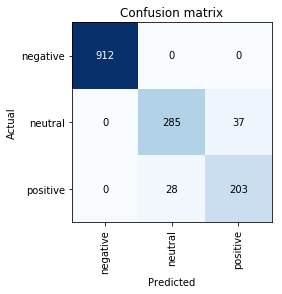

In [64]:
txt_ci.plot_confusion_matrix()

From the above confusion matrix, it is clear that adding the "negativereason' column to the text data helped the model to classifying negative tweets correctly. The confusion is between the neutral and positive tweets. This could be due to incomplete tweet data or no specific data to identity it as positive or neutral.